In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
from tqdm import tqdm
from random import randint


# Torch
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

Total number of images in test data:  7178
Total number of images in train data:  28709
Total number of images in whole dataset:  35887


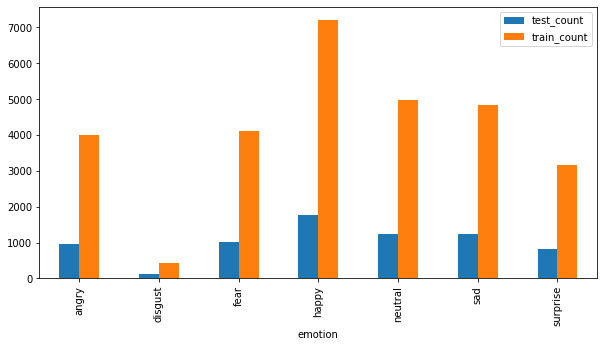

In [2]:
# Data path
test_data_path = '../data/archive/test'
train_data_path = '../data/archive/train'

# each forlder has 7 subfolders representing 7 classes of emotions: anger, disgust, fear, happy, neutral, sad, surprise

#write folder structure
# archive (test, train) -> (anger, disgust, fear, happy, neutral, sad, surprise) -> (images)

# Count number of images in each folder
# Test data
test_data = {}
for folder in os.listdir(test_data_path):
    test_data[folder] = len(os.listdir(os.path.join(test_data_path, folder)))
    
# Train data
train_data = {}
for folder in os.listdir(train_data_path):
    train_data[folder] = len(os.listdir(os.path.join(train_data_path, folder)))

# create  one dataframe for 7 emotion and number of images in each folder for test and train data
df = pd.DataFrame(test_data.items(), columns=['emotion', 'test_count'])
df['train_count'] = train_data.values()

df.plot(x='emotion', y=['test_count', 'train_count'], kind='bar', figsize=(10, 5))

# total number of images in test and train data, and total in whole dataset

test_total = df['test_count'].sum()
train_total = df['train_count'].sum()
total = test_total + train_total
print('Total number of images in test data: ', test_total)
print('Total number of images in train data: ', train_total)
print('Total number of images in whole dataset: ', total)

In [3]:
random_image = cv2.imread(os.path.join(test_data_path, folder, os.listdir(os.path.join(test_data_path, folder))[0]), cv2.IMREAD_GRAYSCALE)
random_image.shape

(48, 48)

# Data Preparation

In [4]:
# check if cuda is available
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print('CUDA is available! Training on GPU...')
else:
    print('CUDA is not available. Training on CPU...')
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available! Training on GPU...
cuda


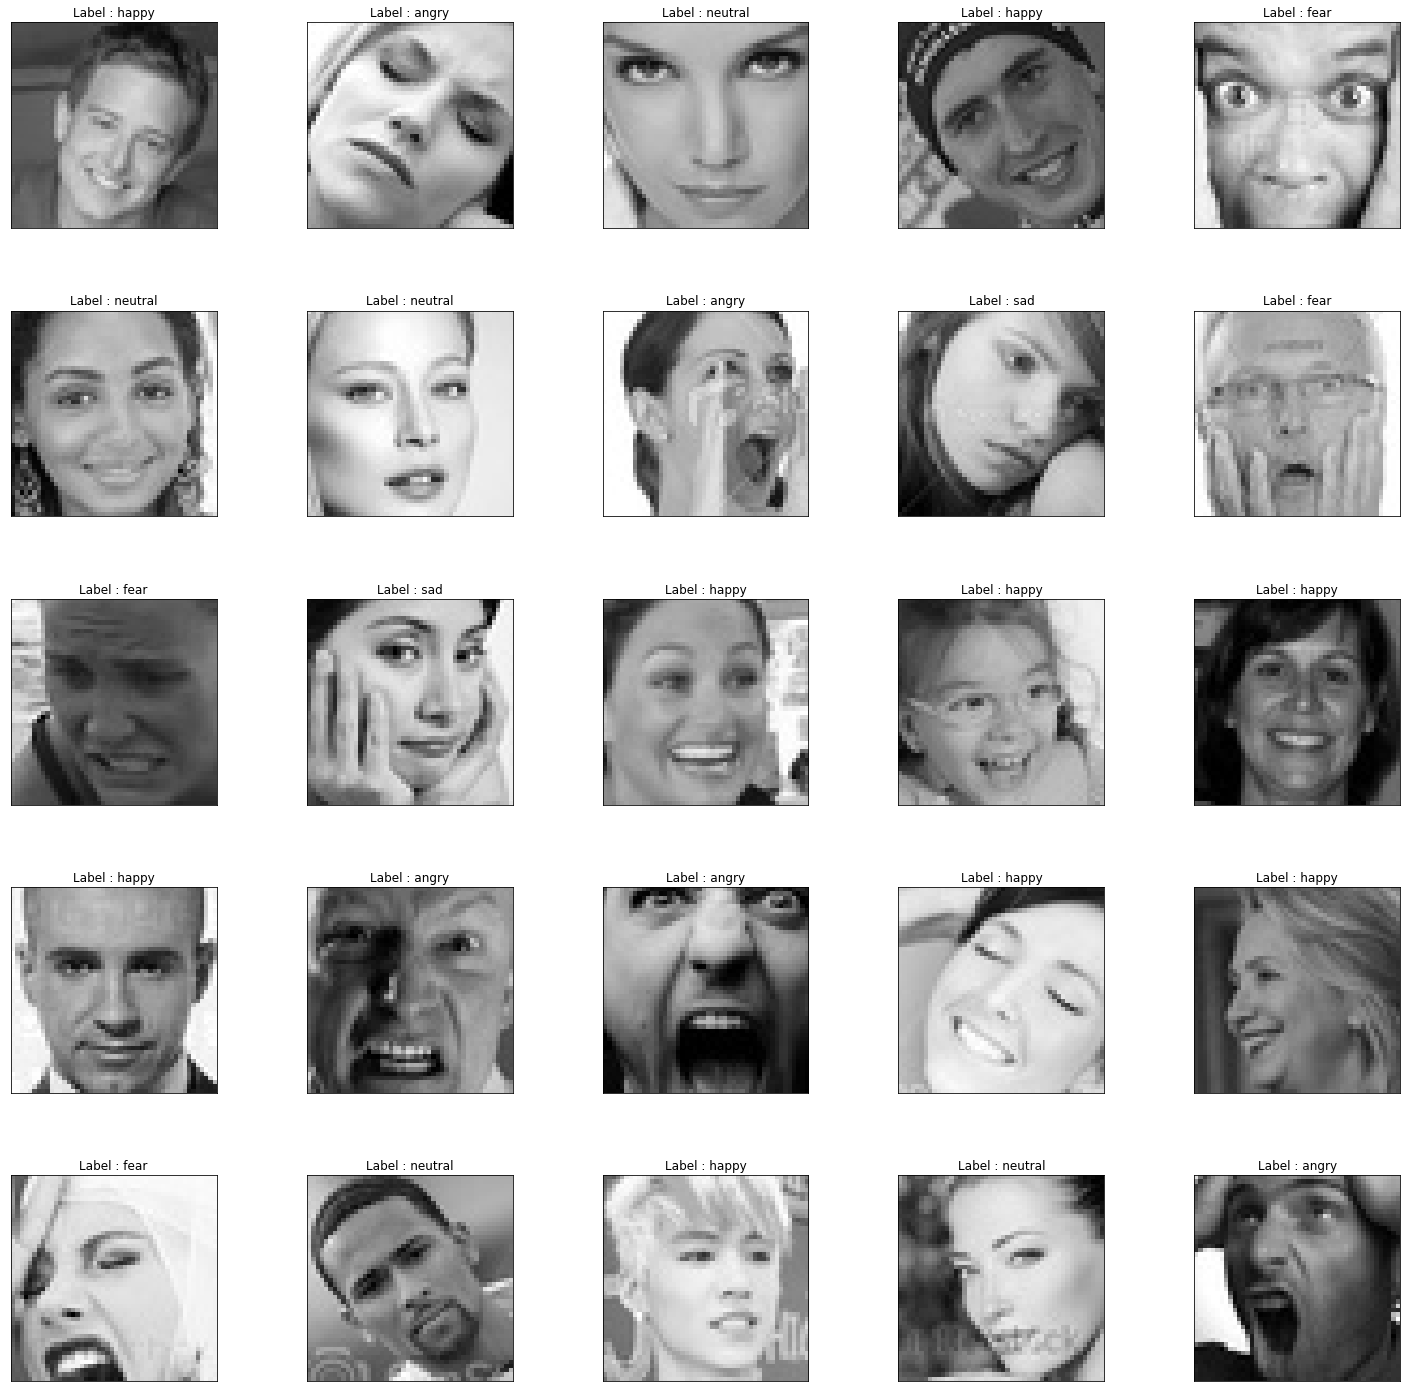

In [5]:
# transform = transforms.Compose([
#     transforms.Resize(32),
#     # to-tensor
#     transforms.ToTensor(),
#     # normalize
#     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
# ])

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        
    ]),
    'test': transforms.Compose([
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# train_data = datasets.ImageFolder(root='../data/archive/train', transform= data_transforms['train'])
# # train_data = datasets.ImageFolder(root='../data/archive/test', transform=transforms.ToTensor())
# test_data = datasets.ImageFolder(root='../data/archive/test', transform= data_transforms['val'])


image_datasets = {x: datasets.ImageFolder(os.path.join('../data/archive', x), transform=data_transforms[x]) 
                  for x in ['train', 'test']}

# image_datasets = { 'train': datasets.ImageFolder(root='../data/archive/train', transform= data_transforms['train']),
#                       'val': datasets.ImageFolder(root='../data/archive/test', transform= data_transforms['val'])}


# Data loaders

dataloaders = {x: DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
               for x in ['train', 'test']}

# # Load data on GPU if available
# if train_on_gpu:
#     train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
#     test_loader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
    
# else:
#     train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
#     test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

# # check if data is loaded correctly
# for images, labels in train_loader:
#     print(images.shape)
#     print(labels.shape)
#     break

class_list = image_datasets['train'].classes

for images, labels in dataloaders['train']:
        # images = images
        #np.unit8
        images = images.numpy()# /2 + 0.5 # earlier data was normalized to [-1, 1] so we need to convert it back to [0, 1]
        # print(images.max(), images.min())
        # break
        images = images.transpose((0, 2, 3, 1))
        
        fig = plt.figure(figsize=(25, 25))
        # set white brackground
        fig.patch.set_facecolor('white')
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        for i in range(25):
            ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
            ax.imshow(images[i])
            
            ax.set_title(f'Label : {class_list[labels[i]]}')
        break
plt.show()


# Model

In [6]:

resnet = models.resnet18(weights= models.ResNet18_Weights.IMAGENET1K_V1)
resnet = resnet.to(device)
resnet.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=5):
    
    for epoch in range(num_epochs):
 
            # print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            # train phase
            model.train()
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(train_loader):
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                # backward pass
                loss.backward()
                optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(train_loader.dataset)
            # print('Training loss: {:.4f}'.format(epoch_loss))
            epoch_acc = running_corrects.double() / len(train_loader.dataset)
            # print('Training accuracy: {:.4f}'.format(epoch_acc))
            
            
            # validation phase
            model.eval()
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in test_loader:
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(test_loader.dataset)
            # print('Validation loss: {:.4f}'.format(epoch_loss))
            epoch_acc = running_corrects.double() / len(test_loader.dataset)
            
            
            print(f'Epoch {epoch}/{num_epochs - 1} -- Training loss: {epoch_loss:.4f}    Training accuracy: {epoch_acc:.4f}   Validation loss: {epoch_loss:.4f}   Validation accuracy: {epoch_acc:.4f}')

    return model


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train the model
# model = train_model(resnet, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=5)
model = train_model(resnet, dataloaders['train'], dataloaders['test'], criterion, optimizer, scheduler, num_epochs=10)



----------


100%|██████████| 449/449 [00:07<00:00, 59.03it/s]


Epoch 0/9 -- Training loss: 1.2321    Training accuracy: 0.5850   Validation loss: 1.2321   Validation accuracy: 0.5850
----------


100%|██████████| 449/449 [00:07<00:00, 57.94it/s]


Epoch 1/9 -- Training loss: 1.2921    Training accuracy: 0.5871   Validation loss: 1.2921   Validation accuracy: 0.5871
----------


100%|██████████| 449/449 [00:07<00:00, 60.44it/s]


Epoch 2/9 -- Training loss: 1.1693    Training accuracy: 0.6043   Validation loss: 1.1693   Validation accuracy: 0.6043
----------


100%|██████████| 449/449 [00:07<00:00, 61.11it/s]


Epoch 3/9 -- Training loss: 1.5029    Training accuracy: 0.6098   Validation loss: 1.5029   Validation accuracy: 0.6098
----------


100%|██████████| 449/449 [00:07<00:00, 60.56it/s]


Epoch 4/9 -- Training loss: 1.7248    Training accuracy: 0.5878   Validation loss: 1.7248   Validation accuracy: 0.5878
----------


100%|██████████| 449/449 [00:07<00:00, 58.55it/s]


Epoch 5/9 -- Training loss: 1.7505    Training accuracy: 0.6066   Validation loss: 1.7505   Validation accuracy: 0.6066
----------


100%|██████████| 449/449 [00:07<00:00, 57.87it/s]


Epoch 6/9 -- Training loss: 1.7833    Training accuracy: 0.5832   Validation loss: 1.7833   Validation accuracy: 0.5832
----------


100%|██████████| 449/449 [00:07<00:00, 58.31it/s]


Epoch 7/9 -- Training loss: 1.8412    Training accuracy: 0.6162   Validation loss: 1.8412   Validation accuracy: 0.6162
----------


100%|██████████| 449/449 [00:07<00:00, 60.25it/s]


Epoch 8/9 -- Training loss: 1.9554    Training accuracy: 0.6021   Validation loss: 1.9554   Validation accuracy: 0.6021
----------


100%|██████████| 449/449 [00:07<00:00, 60.69it/s]


Epoch 9/9 -- Training loss: 2.1464    Training accuracy: 0.5886   Validation loss: 2.1464   Validation accuracy: 0.5886


# Test and Visualize

In [9]:
# image, label = next(iter(dataloaders['train']))
# image = image.to(device)

In [10]:
# # check names of classes
# class_list = image_datasets['train'].classes
# print(class_list)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


1.0 0.0


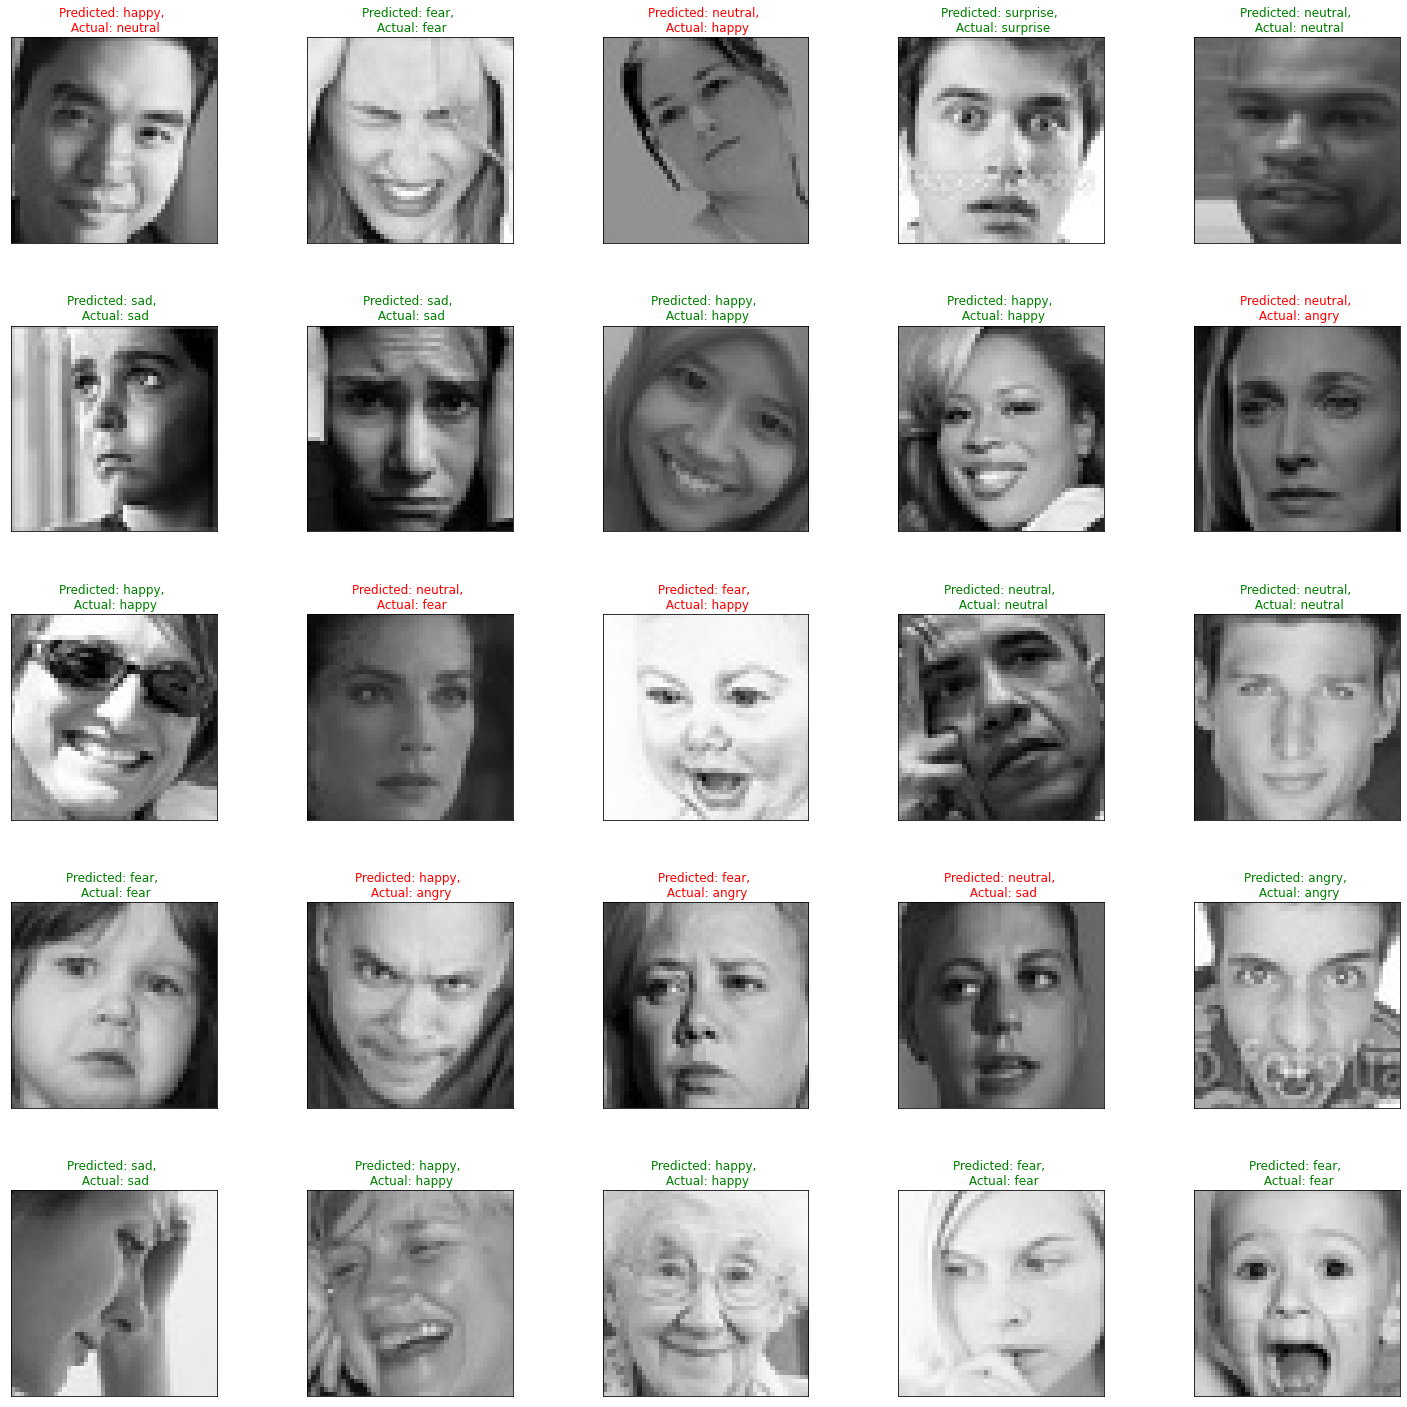

In [13]:
model.eval()
with torch.no_grad():
    for images, labels in dataloaders['test']:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        images = images.cpu().numpy()
        images = images.transpose((0, 2, 3, 1))
        # normalise to 0-1
        # images = (images - images.min())/(images.max() - images.min())
        print(images.max(), images.min())
        
        
        fig = plt.figure(figsize=(25, 25))
        # set white brackground
        fig.patch.set_facecolor('white')
        fig.subplots_adjust(hspace=0.4, wspace=0.4)
        for i in range(25):
            ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
            ax.imshow(images[i])
            predicted_class = class_list[preds[i]]
            actual_class = class_list[labels[i]]
            
            if predicted_class == actual_class:
                ax.set_title(f'Predicted: {predicted_class}, \n Actual: {actual_class}', color='green')
                
            else:
                ax.set_title(f'Predicted: {predicted_class}, \n Actual: {actual_class}', color='red')
            
            ax.set_title(f'Predicted: {predicted_class}, \n Actual: {actual_class}')
        break
    plt.show()